In [1]:
# Imports
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices() # fix to make the script work in the MIT supercloud
from swdf.benchmark import *
from tsai.basics import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
wandb_api = wandb.Api()

# Evaluation of Geomagnetic Indices Dst and Ap

In this notebook, we evaluate the performance of the trained model in comparison to the benchmark established by [Licata et al. (2020)](https://doi.org/10.1029/2020sw002496), for both Ap and Dst indices. In their study, the authors assess the performance of the SOLAR2000 statistical model between the years 2012 and 2018 and provide insights into the performance of traditional models for space weather forecasting.

In [2]:
# Constants
# ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/dst_eval_tmp"

In [3]:
# Config
config = yaml2dict('config/geodst.yaml')
config = config.eval
config

```json
{ 'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'round_preds': True,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'}
```

## Data Preparation

In this section, we will load the trained learner as well as other relevant variables necessary for our evaluation purposes.

In [4]:
# TODO
# learn.path = Path(path)
# learn.model_dir = Path()
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)
learn = load_learner_all(learner_path, learner_fname='learner_geodstap' ,model_fname = 'model_geodstap', 
                         verbose=True, 
                         device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_geodstap.pth'
learner_fname = 'learner_geodstap.pkl'


In [5]:
y_test_preds, y_test, y_test_losses = learn.get_preds(ds_idx = 2, with_targs=True, with_loss=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (15320, 2, 24)


In [6]:
device = 'cuda:0'

y_test_preds = totensor(y_test_preds).to(device)
y_test = totensor(y_test).to(device)

if config.round_preds:
    y_test_preds = y_test_preds.round()
    loss = learn.loss_func(y_test_preds, y_test)
    f'Loss after rounding predictions: {loss}'

In [7]:
learn.validate(ds_idx = 2)

(#10) [6.272867202758789,5.688508987426758,0.5775342583656311,0.0,0.006822874303907156,0.0,0.0,0.0,0.0,0.0]

In [8]:
# Get the average test loss
test_loss = y_test_losses.mean()
print(f"test_loss: {test_loss}")

test_loss: 6.272865295410156


In [9]:
horizon = y_test.shape[-1]
horizon_days = int(np.ceil(horizon / 8))

horizon, horizon_days

(24, 3)

In [10]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")
df_dstap = load_object("./preprocessed_data/dataframes/geodstap.pkl")

In [11]:
df_F10['Datetime'] = df_F10['Datetime'] - pd.Timedelta(hours=12)

# Merge the DST and F10.7 dataframes on the datetime column, and keep only the columns we need
df_combined = pd.merge(df_dstap, df_F10, on='Datetime', how='left')
df_combined = df_combined[['Datetime', 'DST', 'AP', 'F10']]

# The F10 is given only at 12:00 (00:00 now that we shifted), so we'll forward 
# fill the rest of the values
df_combined['F10'] = df_combined['F10'].ffill()
df_combined.head()
df_combined

,Datetime,DST,AP,F10
0,1957-01-01 00:00:00,12.000000,2,255.2
1,1957-01-01 03:00:00,9.300000,3,255.2
2,1957-01-01 06:00:00,5.000000,3,255.2
3,1957-01-01 09:00:00,-5.000000,22,255.2
4,1957-01-01 12:00:00,0.000000,15,255.2
...,...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5,71.3
197519,2024-08-06 21:00:00,-18.700001,6,71.3
197520,2024-08-07 00:00:00,-17.299999,4,71.3
197521,2024-08-07 03:00:00,-16.000000,6,71.3


## Data Classification

Now that we have loaded all the data that we are going to need in order to evaluate our results, we have to classify it in a similar way as the benchmark authors did. In their case, they make a combination of solar activity levels from the F10.7 index and each of the categories of Dst and Ap indices. Finally, the generated categories were:

### Dst Index Categories

| Dst Level | Solar Level | Dst Value         | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| G0        | Low         | Dst ≥ -30         | F 10.7 ≤ 75       |
| G0        | Moderate    | Dst ≥ -30         | 75 < F 10.7 ≤ 150 |
| G0        | Elevated    | Dst ≥ -30         | 150 < F 10.7 ≤ 190|
| G0        | High        | Dst ≥ -30         | F 10.7 > 190      |
| G1        | Low         | -30 > Dst ≥ -50   | F 10.7 ≤ 75       |
| G1        | Moderate    | -30 > Dst ≥ -50   | 75 < F 10.7 ≤ 150 |
| G1        | Elevated    | -30 > Dst ≥ -50   | 150 < F 10.7 ≤ 190|
| G1        | High        | -30 > Dst ≥ -50   | F 10.7 > 190      |
| G2        | Low         | -50 > Dst ≥ -90   | F 10.7 ≤ 75       |
| G2        | Moderate    | -50 > Dst ≥ -90   | 75 < F 10.7 ≤ 150 |
| G2        | Elevated    | -50 > Dst ≥ -90   | 150 < F 10.7 ≤ 190|
| G2        | High        | -50 > Dst ≥ -90   | F 10.7 > 190      |
| G3        | Low         | -90 > Dst ≥ -130  | F 10.7 ≤ 75       |
| G3        | Moderate    | -90 > Dst ≥ -130  | 75 < F 10.7 ≤ 150 |
| G3        | Elevated    | -90 > Dst ≥ -130  | 150 < F 10.7 ≤ 190|
| G3        | High        | -90 > Dst ≥ -130  | F 10.7 > 190      |
| G4        | Low         | -130 > Dst ≥ -350 | F 10.7 ≤ 75       |
| G4        | Moderate    | -130 > Dst ≥ -350 | 75 < F 10.7 ≤ 150 |
| G4        | Elevated    | -130 > Dst ≥ -350 | 150 < F 10.7 ≤ 190|
| G4        | High        | -130 > Dst ≥ -350 | F 10.7 > 190      |
| G5        | Low         | Dst ≤ -350        | F 10.7 ≤ 75       |
| G5        | Moderate    | Dst ≤ -350        | 75 < F 10.7 ≤ 150 |
| G5        | Elevated    | Dst ≤ -350        | 150 < F 10.7 ≤ 190|
| G5        | High        | Dst ≤ -350        | F 10.7 > 190      |

### Ap Index Categories

| Ap Level  | Solar Level | Ap Value          | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| Low       | Low         | Ap ≤ 10           | F 10.7 ≤ 75       |
| Low       | Moderate    | Ap ≤ 10           | 75 < F 10.7 ≤ 150 |
| Low       | Elevated    | Ap ≤ 10           | 150 < F 10.7 ≤ 190|
| Low       | High        | Ap ≤ 10           | F 10.7 > 190      |
| Moderate  | Low         | 10 < Ap ≤ 50      | F 10.7 ≤ 75       |
| Moderate  | Moderate    | 10 < Ap ≤ 50      | 75 < F 10.7 ≤ 150 |
| Moderate  | Elevated    | 10 < Ap ≤ 50      | 150 < F 10.7 ≤ 190|
| Moderate  | High        | 10 < Ap ≤ 50      | F 10.7 > 190      |
| Active    | Low         | Ap > 50           | F 10.7 ≤ 75       |
| Active    | Moderate    | Ap > 50           | 75 < F 10.7 ≤ 150 |
| Active    | Elevated    | Ap > 50           | 150 < F 10.7 ≤ 190|
| Active    | High        | Ap > 50           | F 10.7 > 190      |


In [12]:
geo_thresholds = yaml2dict("preprocessed_data/categorization/thresholds_geodstap.yaml")
geo_levels = yaml2dict("preprocessed_data/categorization/activity_levels_geodstap.yaml")
solfsmy_thresholds = yaml2dict("preprocessed_data/categorization/thresholds_solfsmy.yaml")
solfsmy_levels = yaml2dict("preprocessed_data/categorization/activity_levels_solfsmy.yaml")

In [13]:
all_conditions = {}

for geo_index, geo_level in geo_levels.items():
    solact_levels = solfsmy_levels['F10']  # We're only using F10 in this case
    conditions = []

    # Generate combinations of geo and solar conditions
    for level in geo_level:
        for solact_level in solact_levels:
            if geo_index == 'AP':
                condition = f'{level}Geo_{solact_level.capitalize()}'
            else:
                condition = f'{level}_{solact_level.capitalize()}'

            conditions.append(condition)
    
    # Store the generated conditions for this geomagnetic index
    all_conditions[geo_index] = conditions

all_conditions


{'AP': ['LowGeo_Low',
  'LowGeo_Moderate',
  'LowGeo_Elevated',
  'LowGeo_High',
  'ModerateGeo_Low',
  'ModerateGeo_Moderate',
  'ModerateGeo_Elevated',
  'ModerateGeo_High',
  'ActiveGeo_Low',
  'ActiveGeo_Moderate',
  'ActiveGeo_Elevated',
  'ActiveGeo_High'],
 'DST': ['G0_Low',
  'G0_Moderate',
  'G0_Elevated',
  'G0_High',
  'G1_Low',
  'G1_Moderate',
  'G1_Elevated',
  'G1_High',
  'G2_Low',
  'G2_Moderate',
  'G2_Elevated',
  'G2_High',
  'G3_Low',
  'G3_Moderate',
  'G3_Elevated',
  'G3_High',
  'G4_Low',
  'G4_Moderate',
  'G4_Elevated',
  'G4_High',
  'G5_Low',
  'G5_Moderate',
  'G5_Elevated',
  'G5_High']}

In [14]:
condition_function = create_vectorized_condition_function(geo_thresholds, solfsmy_thresholds, geo_levels, solfsmy_levels)

In [15]:
# Add the condition column to the dataframe
df_combined["DST Condition"] = condition_function('DST', df_combined["DST"], 
                                                 'F10', df_combined["F10"])
df_combined["AP Condition"] = condition_function('AP', df_combined["AP"], 
                                                 'F10', df_combined["F10"])
df_combined

,Datetime,DST,AP,F10,DST Condition,AP Condition
0,1957-01-01 00:00:00,12.000000,2,255.2,G0_High,LowGeo_High
1,1957-01-01 03:00:00,9.300000,3,255.2,G0_High,LowGeo_High
2,1957-01-01 06:00:00,5.000000,3,255.2,G0_High,LowGeo_High
3,1957-01-01 09:00:00,-5.000000,22,255.2,G0_High,ModerateGeo_High
4,1957-01-01 12:00:00,0.000000,15,255.2,G0_High,ModerateGeo_High
...,...,...,...,...,...,...
197518,2024-08-06 18:00:00,-14.300000,5,71.3,G0_Low,LowGeo_Low
197519,2024-08-06 21:00:00,-18.700001,6,71.3,G0_Low,LowGeo_Low
197520,2024-08-07 00:00:00,-17.299999,4,71.3,G0_Low,LowGeo_Low
197521,2024-08-07 03:00:00,-16.000000,6,71.3,G0_Low,LowGeo_Low


In [16]:
X_combined, y_combined = prepare_forecasting_data(df_combined, fcst_history=learn.dls.len, fcst_horizon=learn.dls.d[-1], 
                                x_vars=['DST', 'AP', 'F10', 'Datetime'], 
                                y_vars=['DST', 'AP', 'F10', 'Datetime'])
X_combined.shape, y_combined.shape

((197404, 4, 96), (197404, 4, 24))

> From here in advance we will just split the data, and then format it in order to plot it.

In [17]:
#| export

def split_data_by_dstap_f107(data):
    """
        function that splits the Dst data into all the possible Dst x F10.7 combinations
        according to the thresholds defined above. # The decision is made based on 
        the timestemp of each sample
        The function returns a dictionary with the Dst x F10.7 combinations as keys
        and the corresponding samples that match the condition as values.
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        data_split: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding Dst data as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result_dst = condition_function('DST', first_timestep_data[:, 0], 'F10', first_timestep_data[:, 2])
    result_ap = condition_function('AP', first_timestep_data[:, 1], 'F10', first_timestep_data[:, 2])


    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    data_split = {}
    for dst_condition in all_conditions['DST']:
        data_split[dst_condition] = data[result_dst == dst_condition]
    for ap_condition in all_conditions['AP']:
        data_split[ap_condition] = data[result_ap == ap_condition]
    
    return data_split

def get_idxs_per_dstap_condition(data):
    """
        Function that returns the indices of the samples that match each 
        Dst x F10.7 condition
        Input:
        data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
        Output:
        idxs: dictionary with the Dst x F10.7 combinations as keys, and the
        corresponding indices as values.
    """
    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result_dst = condition_function('DST', first_timestep_data[:, 0], 'F10', first_timestep_data[:, 2])
    result_ap = condition_function('AP', first_timestep_data[:, 1], 'F10', first_timestep_data[:, 2])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values. The keys must be sorted in the same order as the values of 
    # all_possible_dst_conditions
    idxs = {}
    for dst_condition in all_conditions['DST']:
        idxs[dst_condition] = np.where(result_dst == dst_condition)[0]

    for ap_condition in all_conditions['AP']:
        idxs[ap_condition] = np.where(result_ap == ap_condition)[0]
    return idxs

In [18]:
y_combined_train = y_combined[learn.dls[0].splits]
y_combined_valid = y_combined[learn.dls[1].splits]
y_combined_test = y_combined[learn.dls[2].splits]
y_combined_train.shape, y_combined_valid.shape, y_combined_test.shape

((162782, 4, 24), (19160, 4, 24), (15320, 4, 24))

In [19]:
# Splitn y_combined and y_combined_test by Dst x F10.7 combinations
y_combined_train_split = split_data_by_dstap_f107(y_combined_train)
y_combined_valid_split = split_data_by_dstap_f107(y_combined_valid)
y_combined_test_split = split_data_by_dstap_f107(y_combined_test)

# Compare the distributions of the Dst x F10.7 combinations in the training, validation and test sets
print('{:<20} {:<20} {:<20} {}'.format("Condition", "Train", "Valid", "Test"))
for key in all_conditions['DST'] + all_conditions['AP']:
    print('{:<20} {:<20} {:<20} {}'.format(
        key, 
        str(ifnone(y_combined_train_split.get(key),np.array([])).shape),
        str(ifnone(y_combined_valid_split.get(key), np.array([])).shape), 
        str(ifnone(y_combined_test_split.get(key), np.array([])).shape)))

Condition            Train                Valid                Test
G0_Low               (27503, 4, 24)       (17784, 4, 24)       (1750, 4, 24)
G0_Moderate          (67723, 4, 24)       (36, 4, 24)          (9724, 4, 24)
G0_Elevated          (18154, 4, 24)       (0, 4, 24)           (1267, 4, 24)
G0_High              (15571, 4, 24)       (0, 4, 24)           (149, 4, 24)
G1_Low               (1986, 4, 24)        (963, 4, 24)         (127, 4, 24)
G1_Moderate          (9342, 4, 24)        (4, 4, 24)           (1175, 4, 24)
G1_Elevated          (3708, 4, 24)        (0, 4, 24)           (162, 4, 24)
G1_High              (3985, 4, 24)        (0, 4, 24)           (33, 4, 24)
G2_Low               (415, 4, 24)         (291, 4, 24)         (16, 4, 24)
G2_Moderate          (3564, 4, 24)        (0, 4, 24)           (379, 4, 24)
G2_Elevated          (1805, 4, 24)        (0, 4, 24)           (56, 4, 24)
G2_High              (2404, 4, 24)        (0, 4, 24)           (1, 4, 24)
G3_Low               

In [20]:
# Get the idxs (with respect to the test set) of the samples that match 
# each Dst x F10.7 condition
y_test_split_idxs = get_idxs_per_dstap_condition(y_combined_test)
for key, value in y_test_split_idxs.items():
    print(key, value.shape)

G0_Low (1750,)
G0_Moderate (9724,)
G0_Elevated (1267,)
G0_High (149,)
G1_Low (127,)
G1_Moderate (1175,)
G1_Elevated (162,)
G1_High (33,)
G2_Low (16,)
G2_Moderate (379,)
G2_Elevated (56,)
G2_High (1,)
G3_Low (0,)
G3_Moderate (64,)
G3_Elevated (3,)
G3_High (1,)
G4_Low (0,)
G4_Moderate (13,)
G4_Elevated (0,)
G4_High (0,)
G5_Low (0,)
G5_Moderate (0,)
G5_Elevated (0,)
G5_High (0,)
LowGeo_Low (1310,)
LowGeo_Moderate (8342,)
LowGeo_Elevated (1111,)
LowGeo_High (137,)
ModerateGeo_Low (570,)
ModerateGeo_Moderate (2810,)
ModerateGeo_Elevated (357,)
ModerateGeo_High (44,)
ActiveGeo_Low (13,)
ActiveGeo_Moderate (203,)
ActiveGeo_Elevated (20,)
ActiveGeo_High (3,)


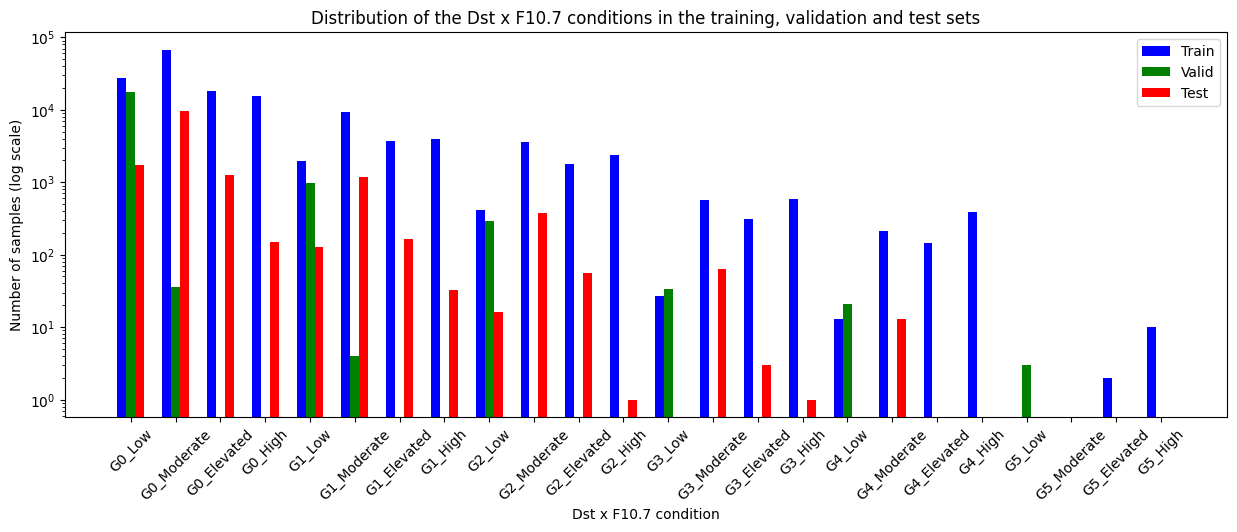

In [21]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the Dst x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_conditions['DST']))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_conditions['DST']],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_conditions['DST'])),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_conditions['DST']], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_conditions['DST']))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_conditions['DST']],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_conditions['DST'])))
ax.set_xticklabels(all_conditions['DST'], rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('Dst x F10.7 condition')
ax.set_title('Distribution of the Dst x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

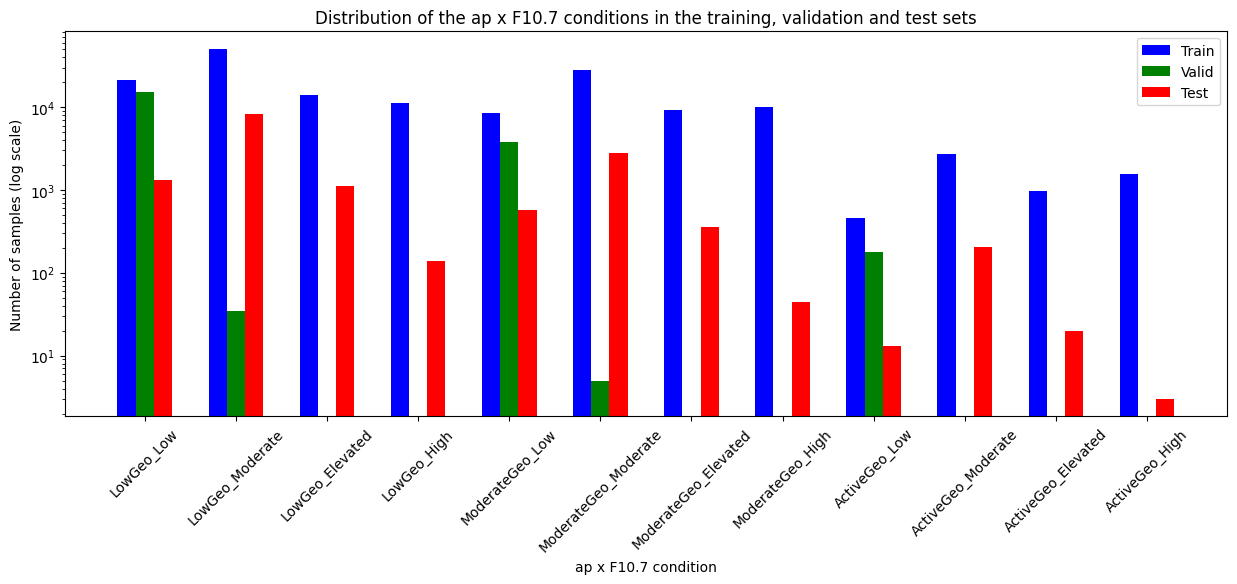

In [22]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the ap x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_conditions['AP']))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_conditions['AP']],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_conditions['AP'])),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_conditions['AP']], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_conditions['AP']))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_conditions['AP']],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_conditions['AP'])))
ax.set_xticklabels(all_conditions['AP'], rotation=45)
ax.set_ylabel('Number of samples (log scale)')
ax.set_yscale('log')
ax.set_xlabel('ap x F10.7 condition')
ax.set_title('Distribution of the ap x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()

In [23]:
# Split y_test and y_test_preds with the idxs from y_test_split_idxs
y_test_split = {}
y_test_preds_split = {}
for key, value in y_test_split_idxs.items():
    y_test_split[key] = y_test[value]
    y_test_preds_split[key] = y_test_preds[value]

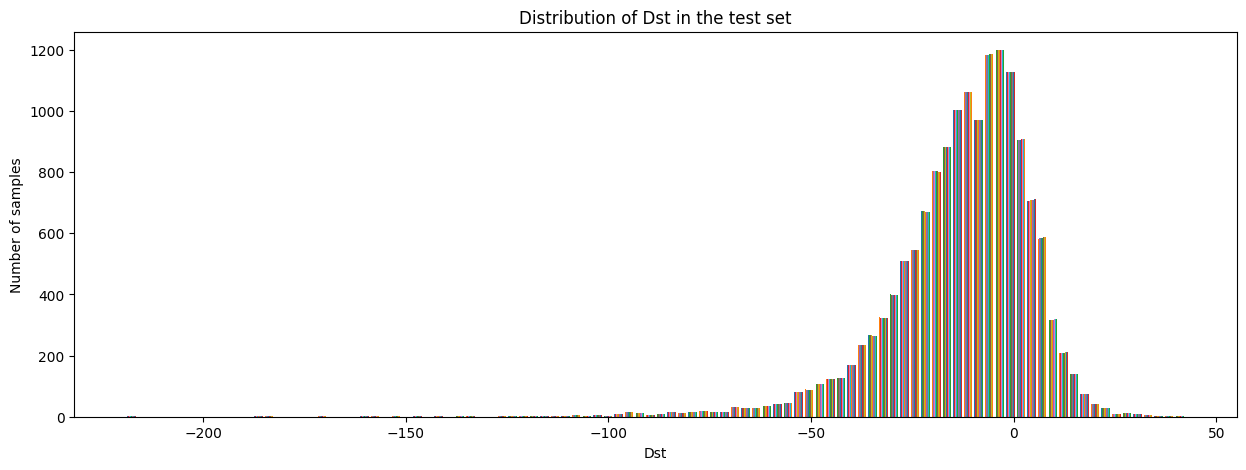

In [24]:
# Plot the distribution of y_test
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(y_test[:, 0, :].cpu(), bins=100)
ax.set_xlabel('Dst')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of Dst in the test set')
plt.show()


In [25]:
# Create a dataframe with the mean forecast error for the Dst in each 
# Dst x F10.7 condition and each horizon. The horizon is given in days in the
# dataframe, but the actual horizon in the data is given in hours
data = []
for condition in all_conditions['DST'] + all_conditions['AP']:
    if y_test_split.get(condition) is not None and \
    y_test_split.get(condition).shape[0] > 0:
        # Apply forecast_error to every horizon (1..horizon)
        fe_sfu = np.array([forecast_error(y_test_split[condition][:, 0, :].cpu(),
                                        y_test_preds_split[condition][:, 0, :].cpu(), 
                                        h) for h in range(1, horizon+1)]).astype(np.float64)
        fe_percent = np.array([percent_forecast_error(y_test_split[condition][:, 0, :].cpu(),
                                                    y_test_preds_split[condition][:, 0, :].cpu(), 
                                                    h) for h in range(1, horizon+1)]).astype(np.float64)
        # Aggregate the forecast every 8 hours (get mean and std)
        # TODO: This code breaks if the max horizon is not a multiple of 8
        fe_nT_mean = np.array([np.mean(fe_sfu[i:i+8]) for i in range(0, horizon, 8)])
        fe_nT_std = np.array([np.std(fe_sfu[i:i+8]) for i in range(0, horizon, 8)])
        #fe_percent_mean = np.array([np.mean(fe_percent[i:i+8]) for i in range(0, horizon, 8)])
        #fe_percent_std = np.array([np.std(fe_percent[i:i+8]) for i in range(0, horizon, 8)])
        # additional columns
        h_days = np.arange(1, (horizon // 8) + 1)
        n_samples = y_test_split[condition].shape[0]
        # Append the data to the list
        for h_day, mean, std in zip(h_days, fe_nT_mean, fe_nT_std):
            data.append((condition, h_day, mean, std, n_samples))
# Create the dataframe        
df_results = pd.DataFrame(data, columns=['condition', 'horizon_days', 
                                         'fe_nT_mean', 'fe_nT_std', 'n_samples'])
df_results.head(10)

,condition,horizon_days,fe_nT_mean,fe_nT_std,n_samples
0,G0_Low,1,-0.833593,8.438503,1750
1,G0_Low,2,-1.282221,11.368937,1750
2,G0_Low,3,-1.140100,13.160877,1750
3,G0_Moderate,1,0.387933,12.244555,9724
4,G0_Moderate,2,1.637414,17.153396,9724
5,G0_Moderate,3,2.476717,18.451021,9724
6,G0_Elevated,1,0.459599,10.763278,1267
7,G0_Elevated,2,1.177032,13.592885,1267
8,G0_Elevated,3,1.537934,14.627831,1267
9,G0_High,1,3.298742,16.341136,149


In [26]:
# compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_dst_paper = pd.read_csv('../data/benchmark_results_dst.csv', comment = '#')
df_results_ap_paper = pd.read_csv('../data/benchmark_results_ap.csv', comment = '#')

df_results_paper = pd.concat([df_results_dst_paper, df_results_ap_paper])

df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']
# Rename mu with fe_nT_mean and sigma with fe_nT_std in the statistics column
df_results_paper['statistic'] = df_results_paper['statistic'].replace({
    'mu': 'fe_nT_mean', 
    'sigma': 'fe_nT_std'
    })
df_results_paper.tail()

,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
13,LowGeo_Elevated,fe_nT_std,7.2675,7.6940,7.9520,9.0765,8.6062,6.2746
15,ModGeo_Elevated,fe_nT_mean,2.9701,2.7038,1.2755,-7.7028,-7.6295,-8.0547
16,ModGeo_Elevated,fe_nT_std,10.9766,12.0786,11.9995,10.0915,10.2440,10.7734
18,ModGeo_High,fe_nT_mean,8.1667,5.2540,0.5079,-7.9921,-9.0397,-10.3968
19,ModGeo_High,fe_nT_std,15.2611,12.7671,8.9307,7.3996,8.1156,10.3549


In [27]:
# Convert the dfs with results into long format
df_results_long = pd.melt(df_results, id_vars=['condition', 'horizon_days'],
                            value_vars=['fe_nT_mean', 'fe_nT_std'],
                            var_name='statistic', value_name='value')
df_results_long.head()

,condition,horizon_days,statistic,value
0,G0_Low,1,fe_nT_mean,-0.833593
1,G0_Low,2,fe_nT_mean,-1.282221
2,G0_Low,3,fe_nT_mean,-1.140100
3,G0_Moderate,1,fe_nT_mean,0.387933
4,G0_Moderate,2,fe_nT_mean,1.637414


In [28]:
df_results_paper_long = df_results_paper.melt(id_vars=['condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon_days+1)],
                                            var_name='horizon_days', value_name='value')
df_results_paper_long['horizon_days'] = df_results_paper_long['horizon_days'].str.replace(
    ' Days', '').astype(int)
df_results_paper_long.head()

,condition,statistic,horizon_days,value
0,G0_Low,fe_nT_mean,1,1.1077
1,G0_Low,fe_nT_std,1,14.6264
2,G0_Moderate,fe_nT_mean,1,8.8130
3,G0_Moderate,fe_nT_std,1,18.2244
4,G0_Elevated,fe_nT_mean,1,9.6871


In [29]:
# Join the two dataframes (paper and ours) into one, merging on the condition and
# statistic. Right merge (paper)
df_results_merged = pd.merge(df_results_long, df_results_paper_long,
                            on=['condition', 'statistic', 'horizon_days'], how='right',
                            suffixes=('_ours', '_benchmark'))

df_results_merged

,condition,horizon_days,statistic,value_ours,value_benchmark
0,G0_Low,1,fe_nT_mean,-0.833593,1.1077
1,G0_Low,1,fe_nT_std,8.438503,14.6264
2,G0_Moderate,1,fe_nT_mean,0.387933,8.8130
3,G0_Moderate,1,fe_nT_std,12.244555,18.2244
4,G0_Elevated,1,fe_nT_mean,0.459599,9.6871
...,...,...,...,...,...
91,LowGeo_Elevated,3,fe_nT_std,15.026752,7.9520
92,ModGeo_Elevated,3,fe_nT_mean,NaN,1.2755
93,ModGeo_Elevated,3,fe_nT_std,NaN,11.9995
94,ModGeo_High,3,fe_nT_mean,NaN,0.5079


In [30]:
data_dst = df_results_merged[df_results_merged.condition.isin(all_conditions['DST'])].copy()
data_dst[['Dst level', 'Solar activity level']] = data_dst.condition.str.split('_', expand=True)

data_ap = df_results_merged[df_results_merged.condition.isin(all_conditions['AP'])].copy()
data_ap[['Ap level', 'Solar activity level']] = data_ap['condition'].str.split('_', expand=True)

In [31]:
# Preprocess the data
def plot_results(data:pd.DataFrame, data_column:str): 

    # Separate mean and std dataframes
    mean_df = data[data['statistic'] == 'fe_nT_mean'].copy()
    std_df = data[data['statistic'] == 'fe_nT_std'].copy()

    # Rename columns for merging
    mean_df.rename(columns={'value_ours': 'mean_ours', 'value_benchmark': 'mean_benchmark'}, inplace=True)
    std_df.rename(columns={'value_ours': 'std_ours', 'value_benchmark': 'std_benchmark'}, inplace=True)

    # Melt the data to a long format
    melted_mean_data = pd.melt(mean_df, id_vars=[data_column, 'Solar activity level', 'horizon_days'], 
                            value_vars=['mean_ours', 'mean_benchmark'], 
                            var_name='algorithm', value_name='mean')

    melted_std_data = pd.melt(std_df, id_vars=[data_column, 'Solar activity level', 'horizon_days'], 
                            value_vars=['std_ours', 'std_benchmark'], 
                            var_name='algorithm', value_name='std')

    # Correct the 'algorithm' column in the std melted dataframe
    melted_std_data['algorithm'] = melted_std_data['algorithm'].str.replace('std', 'mean')

    # Merge the mean and std melted dataframes
    melted_data = pd.merge(melted_mean_data, melted_std_data, on=[data_column, 
                                                                'Solar activity level', 'horizon_days', 'algorithm'])

    # Create the faceted line charts
    g = sns.FacetGrid(melted_data, row=data_column, col='Solar activity level', hue='algorithm', 
                    margin_titles=True, sharey=False)

    def plot_func(x, y1, y2, **kwargs):
        plt.plot(x, y1, marker='o', **kwargs)
        plt.fill_between(x, y1 - y2, y1 + y2, alpha=0.2)

    g.map(plt.axhline, y=0, ls='--', c='black', alpha=0.4)  # Add this line
    g.map(plot_func, 'horizon_days', 'mean', 'std')

    g.set_xlabels("Horizon (days)")
    g.set_ylabels("Forecast error (nT)")
    g.add_legend(title='Algorithm')

    # Change legend labels
    new_labels = ['Ours', 'Benchmark']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

    g.fig.subplots_adjust(wspace=.2, hspace=.2)
    plt.show()


## Results Plotting

Finally, let's plot the results.

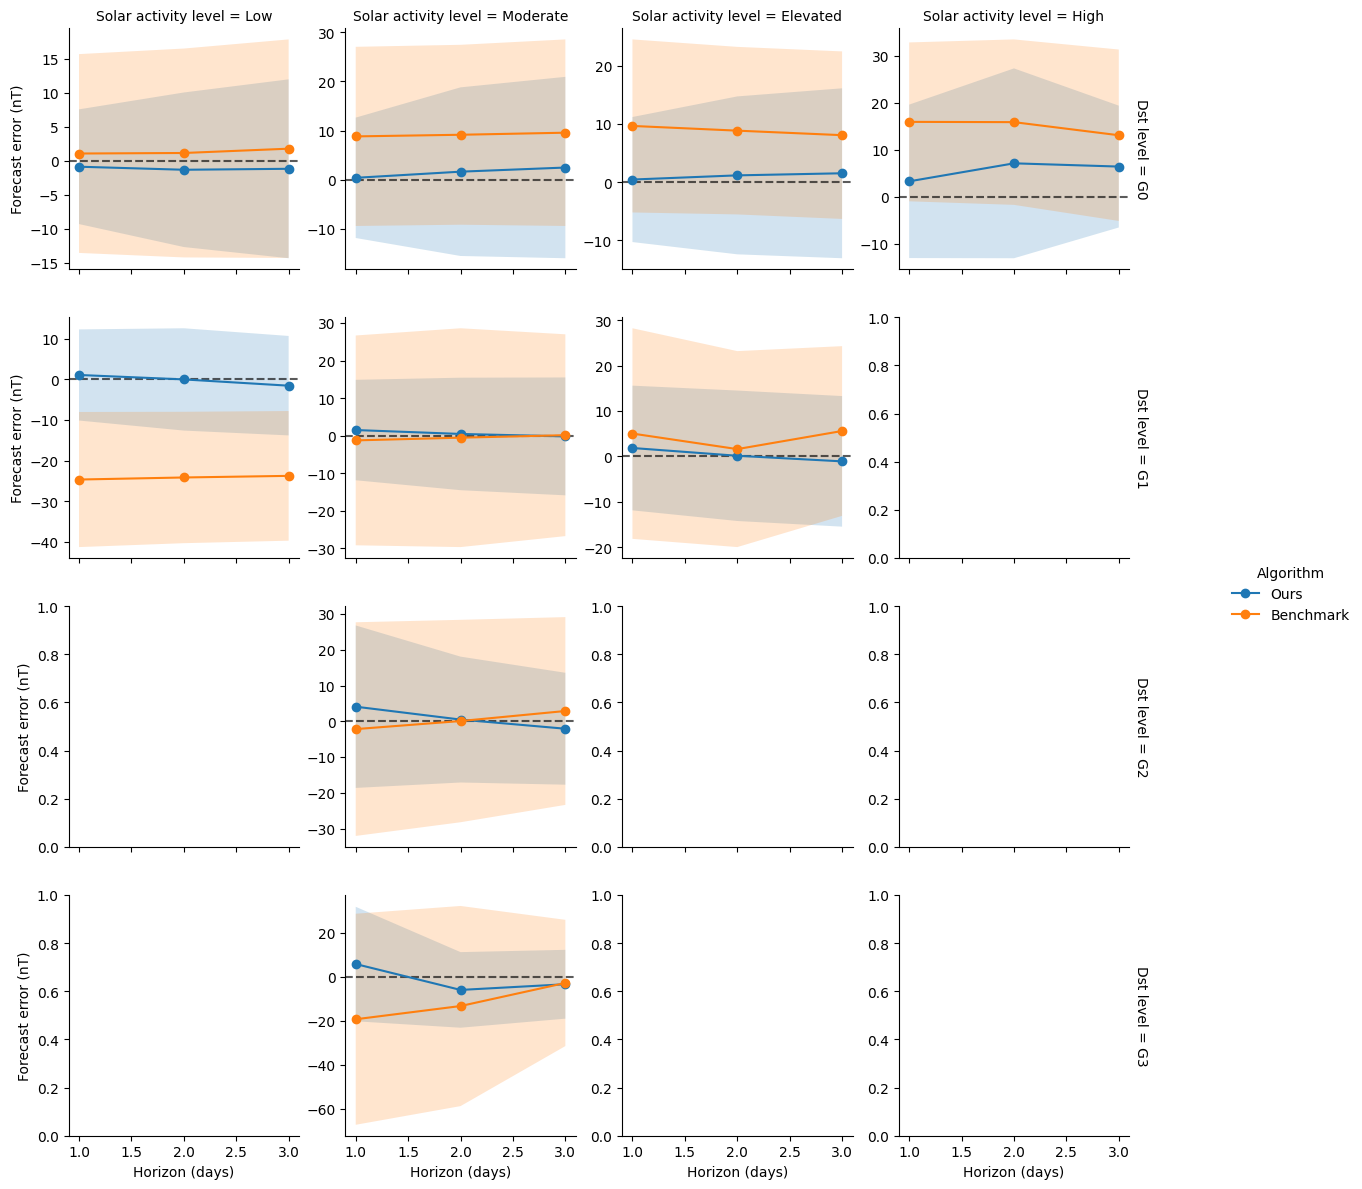

In [32]:
plot_results(data_dst, 'Dst level') 

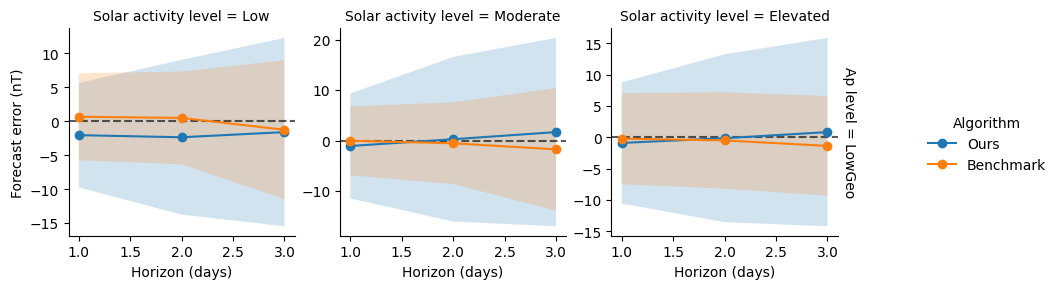

In [33]:
plot_results(data_ap, 'Ap level')